# Cox生存分析

* `mydir`：自己的数据
* `ostime_column`: 数据对应的生存时间，不一定非的是OST，也可以是DST、FST等。
* `os`：生存状态，不一定非的是OS，也可以是DS、FS等。

In [1]:
import os
from IPython.display import display
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from onekey_algo import OnekeyDS as okds
from onekey_algo import get_param_in_cwd
import pandas as pd

os.makedirs('img', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('features', exist_ok=True)

# 设置数据目录
survival_type = 'OS'
task_type = f'Clinical-{survival_type}_'
# 对应的标签文件
group_info = get_param_in_cwd('dataset_column') or 'group'
survival_data = pd.read_csv(get_param_in_cwd('survival_file'))[['ID', survival_type, f"{survival_type}TIME"]]
labelf = 'group.csv'
# 读取标签数据列名
labels = [get_param_in_cwd('task_column') or 'label']

In [2]:
from lifelines import CoxPHFitter
import pandas as pd
from onekey_algo.custom.components.comp1 import normalize_df
from sklearn.model_selection import train_test_split
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.components.comp1 import fillna

event_col = survival_type
duration_col = f"{survival_type}TIME"

data = pd.read_csv('data/clinical.csv', dtype={'ID':str})
data = pd.merge(data, survival_data.drop_duplicates(), on='ID', how='inner')
data = data[[c for c in data.columns if c not in set(['DFSTIME', 'OSTIME', 'DFS', 'OS']) - set([duration_col, event_col])]]
# data = normalize_df(data, not_norm=['ID', 'group'])
# label_data = pd.read_csv(get_param_in_cwd('label_file'), dtype={'ID':str})[['ID', event_col, duration_col]]
# label_data['ID'] = label_data['ID'].map(lambda x: f"{int(x)}.nii.gz")
# data = pd.merge(data, label_data, on='ID', how='inner')
data

,ID,age_at_surgery,sex,height,weight,BMI,SMA,SMI,sarcopenia,clinical_stage,...,Neoadjuvant_therapy,Adjuvant_chemotherapy,Adjuvant_radiotherapy,pN_stage,pT_stage,lymphovascular_invasion,perineural_invasion,group,OS,OSTIME
0,primary-1.nii.gz,64,1,1.65,80.0,29.385,161.3,59.247,0,0,...,0,0,0,0,3,0,0,train,1,20
1,primary-3.nii.gz,56,1,1.78,80.0,25.249,179.4,56.622,0,1,...,1,1,0,2,3,0,0,train,0,53
2,primary-4.nii.gz,56,1,1.70,61.0,21.107,134.2,46.436,0,0,...,1,1,0,0,2,0,1,train,0,53
3,primary-6.nii.gz,67,1,1.80,76.0,23.457,169.4,52.284,0,0,...,0,1,1,1,3,0,0,val,0,51
4,primary-7.nii.gz,68,1,1.78,85.0,26.827,160.7,50.720,0,0,...,0,1,1,0,3,1,0,val,0,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,secondary2-66.nii.gz,51,1,1.74,78.0,25.763,169.2,55.886,0,0,...,0,1,1,0,3,0,0,test,0,47
454,secondary2-67.nii.gz,66,1,1.72,82.0,27.718,166.3,56.213,0,0,...,0,1,1,0,3,1,0,test,0,56
455,secondary2-69.nii.gz,67,1,1.67,65.0,23.307,162.1,58.123,0,1,...,0,0,0,1,3,0,0,test,0,40
456,secondary2-71.nii.gz,54,1,1.62,72.0,27.435,160.8,61.271,0,1,...,0,1,1,2,3,1,1,test,0,39


In [3]:
import numpy as np
import onekey_algo.custom.components as okcomp
from collections import OrderedDict

group_info = 'group'
train_data = data[(data[group_info] == 'train')]

# subsets = [s for s in label_data['group'].value_counts().index if s != 'train']
subsets = get_param_in_cwd('subsets')
val_datasets = OrderedDict()
for subset in subsets:
    val_data = data[data[group_info] == subset]
    val_datasets[subset] = val_data
    val_data.to_csv(f'features/{task_type}{subset}_features_norm.csv', index=False)

print('，'.join([f"{subset}样本数：{d_.shape}" for subset, d_ in val_datasets.items()]))

train样本数：(268, 25)，val样本数：(115, 25)，test样本数：(75, 25)


In [4]:
import os
from onekey_algo.custom.components.survival import uni_cox

if os.path.exists(f'features/{task_type}rad_features_unisel.csv') and False:
    train_data = pd.read_csv(f'features/{task_type}rad_features_unisel.csv')
else:
    sel_features, uni_info = uni_cox(train_data, duration_col=duration_col, event_col=event_col,
                                     cols=[c for c in train_data.columns if c not in [event_col, duration_col, 'ID', 'group']], 
                                     pvalue_thres=0.05, verbose=True)
    train_data = train_data[['ID'] + sel_features + [event_col, duration_col, 'group']]
    train_data.to_csv(f'features/{task_type}rad_features_unisel.csv', header=True, index=False)
train_data

[2024-11-25 10:49:53 - survival.py:  49]	INFO	age_at_surgery的pvalue: 0.20186021167756996
[2024-11-25 10:49:53 - survival.py:  49]	INFO	sex的pvalue: 0.18027619148044138
[2024-11-25 10:49:53 - survival.py:  49]	INFO	height的pvalue: 0.5124634325499603
[2024-11-25 10:49:53 - survival.py:  49]	INFO	weight的pvalue: 0.978463439347302
[2024-11-25 10:49:53 - survival.py:  49]	INFO	BMI的pvalue: 0.6671306614650085
[2024-11-25 10:49:53 - survival.py:  49]	INFO	SMA的pvalue: 0.8163791064001351
[2024-11-25 10:49:53 - survival.py:  49]	INFO	SMI的pvalue: 0.9846340465641131
[2024-11-25 10:49:53 - survival.py:  49]	INFO	sarcopenia的pvalue: 0.015457758040857727
[2024-11-25 10:49:53 - survival.py:  49]	INFO	clinical_stage的pvalue: 0.08268657499706182
[2024-11-25 10:49:53 - survival.py:  49]	INFO	clinical_T_stage的pvalue: 0.4616120262967627
[2024-11-25 10:49:53 - survival.py:  49]	INFO	Lymph_node_status的pvalue: 0.21683429006223814
[2024-11-25 10:49:53 - survival.py:  49]	INFO	location的pvalue: 0.3894155107883056
[202

,ID,sarcopenia,pN_stage,OS,OSTIME,group
0,primary-1.nii.gz,0,0,1,20,train
1,primary-3.nii.gz,0,2,0,53,train
2,primary-4.nii.gz,0,0,0,53,train
5,primary-10.nii.gz,0,0,0,48,train
7,primary-12.nii.gz,1,0,1,43,train
...,...,...,...,...,...,...
375,primary-393.nii.gz,1,1,1,30,train
377,primary-395.nii.gz,1,0,0,64,train
379,primary-397.nii.gz,0,0,1,24,train
380,primary-398.nii.gz,1,1,1,24,train


## Cox概览

所有Cox回归的必要数据，主要关注的数据有3个
1. `Concordance`: c-index
2. `exp(coef)`: 每个特征对应的HR，同时也有期对应的95%分位数。
3. `p`: 表示特征是否显著。

In [5]:
from lifelines import CoxPHFitter
mci = 0
for p in range(100):
    cph = CoxPHFitter(penalizer=p/100)
    cph.fit(train_data[[c for c in train_data.columns if c not in ['ID', 'group']]], duration_col=duration_col, event_col=event_col)
    test_data = val_datasets['test']
    ci = cph.score(test_data[[c for c in test_data.columns if c not in ['ID', 'group']]], scoring_method="concordance_index")
    if mci < ci:
        print(p, ci)
        mci = ci

0 0.7556109725685786


In [6]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)
cph.fit(train_data[[c for c in train_data.columns if c not in ['ID', 'group']]], duration_col=duration_col, event_col=event_col)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 268 total observations, 214 right-censored observations>
             duration col = 'OSTIME'
                event col = 'OS'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 268
number of events observed = 54
   partial log-likelihood = -284.54
         time fit was run = 2024-11-25 02:50:01 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
sarcopenia   0.58       1.79       0.24             0.11             1.05                 1.12                 2.86
pN_stage     0.45       1.56       0.17             0.12             0.77                 1.13                 2.17

             cmp to    z    p   -log2(p)
covariate                               
sarcopenia     0.00 2.43 0.02       6.04
pN_stage       0.00 2.68 0.01       7.10
---
Concordance = 0.67
Partial AIC = 573.08
log-likelihood ratio test = 12.60 on 2 df
-log2(p) of ll-ratio test = 9.09

In [7]:
multi_info = cph.summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']].reset_index()
i = pd.merge(uni_info, multi_info, on='covariate', how='left', suffixes=['_Uni', '_Multi'])
i['p_Uni'] = i['p_Uni'].map(lambda x: '<0.05' if not pd.isna(x) and x < 0.05 else x)
i['p_Multi'] = i['p_Multi'].map(lambda x: '<0.05' if not pd.isna(x) and x < 0.05 else x)
i.columns = ['features_name', 'HR', 'lower 95%CI', 'upper 95%CI', 'pvalue', 'HR', 'lower 95%CI', 'upper 95%CI', 'pvalue']
i.applymap(lambda x: '' if pd.isna(x) else x)

,features_name,HR,lower 95%CI,upper 95%CI,pvalue,HR,lower 95%CI,upper 95%CI,pvalue
0,age_at_surgery,1.013,0.993,1.033,0.202,,,,
1,sex,1.386,0.860,2.234,0.18,,,,
2,height,2.642,0.144,48.368,0.512,,,,
3,weight,1.000,0.979,1.021,0.978,,,,
4,BMI,0.985,0.919,1.055,0.667,,,,
5,SMA,1.001,0.994,1.008,0.816,,,,
6,SMI,1.000,0.975,1.025,0.985,,,,
7,sarcopenia,1.786,1.117,2.857,<0.05,1.788,1.118,2.86,<0.05
8,clinical_stage,1.487,0.950,2.327,0.083,,,,
9,clinical_T_stage,1.244,0.695,2.227,0.462,,,,


#### 输出每个特征的HR

In [8]:
cph.concordance_index_

0.6662939032471835

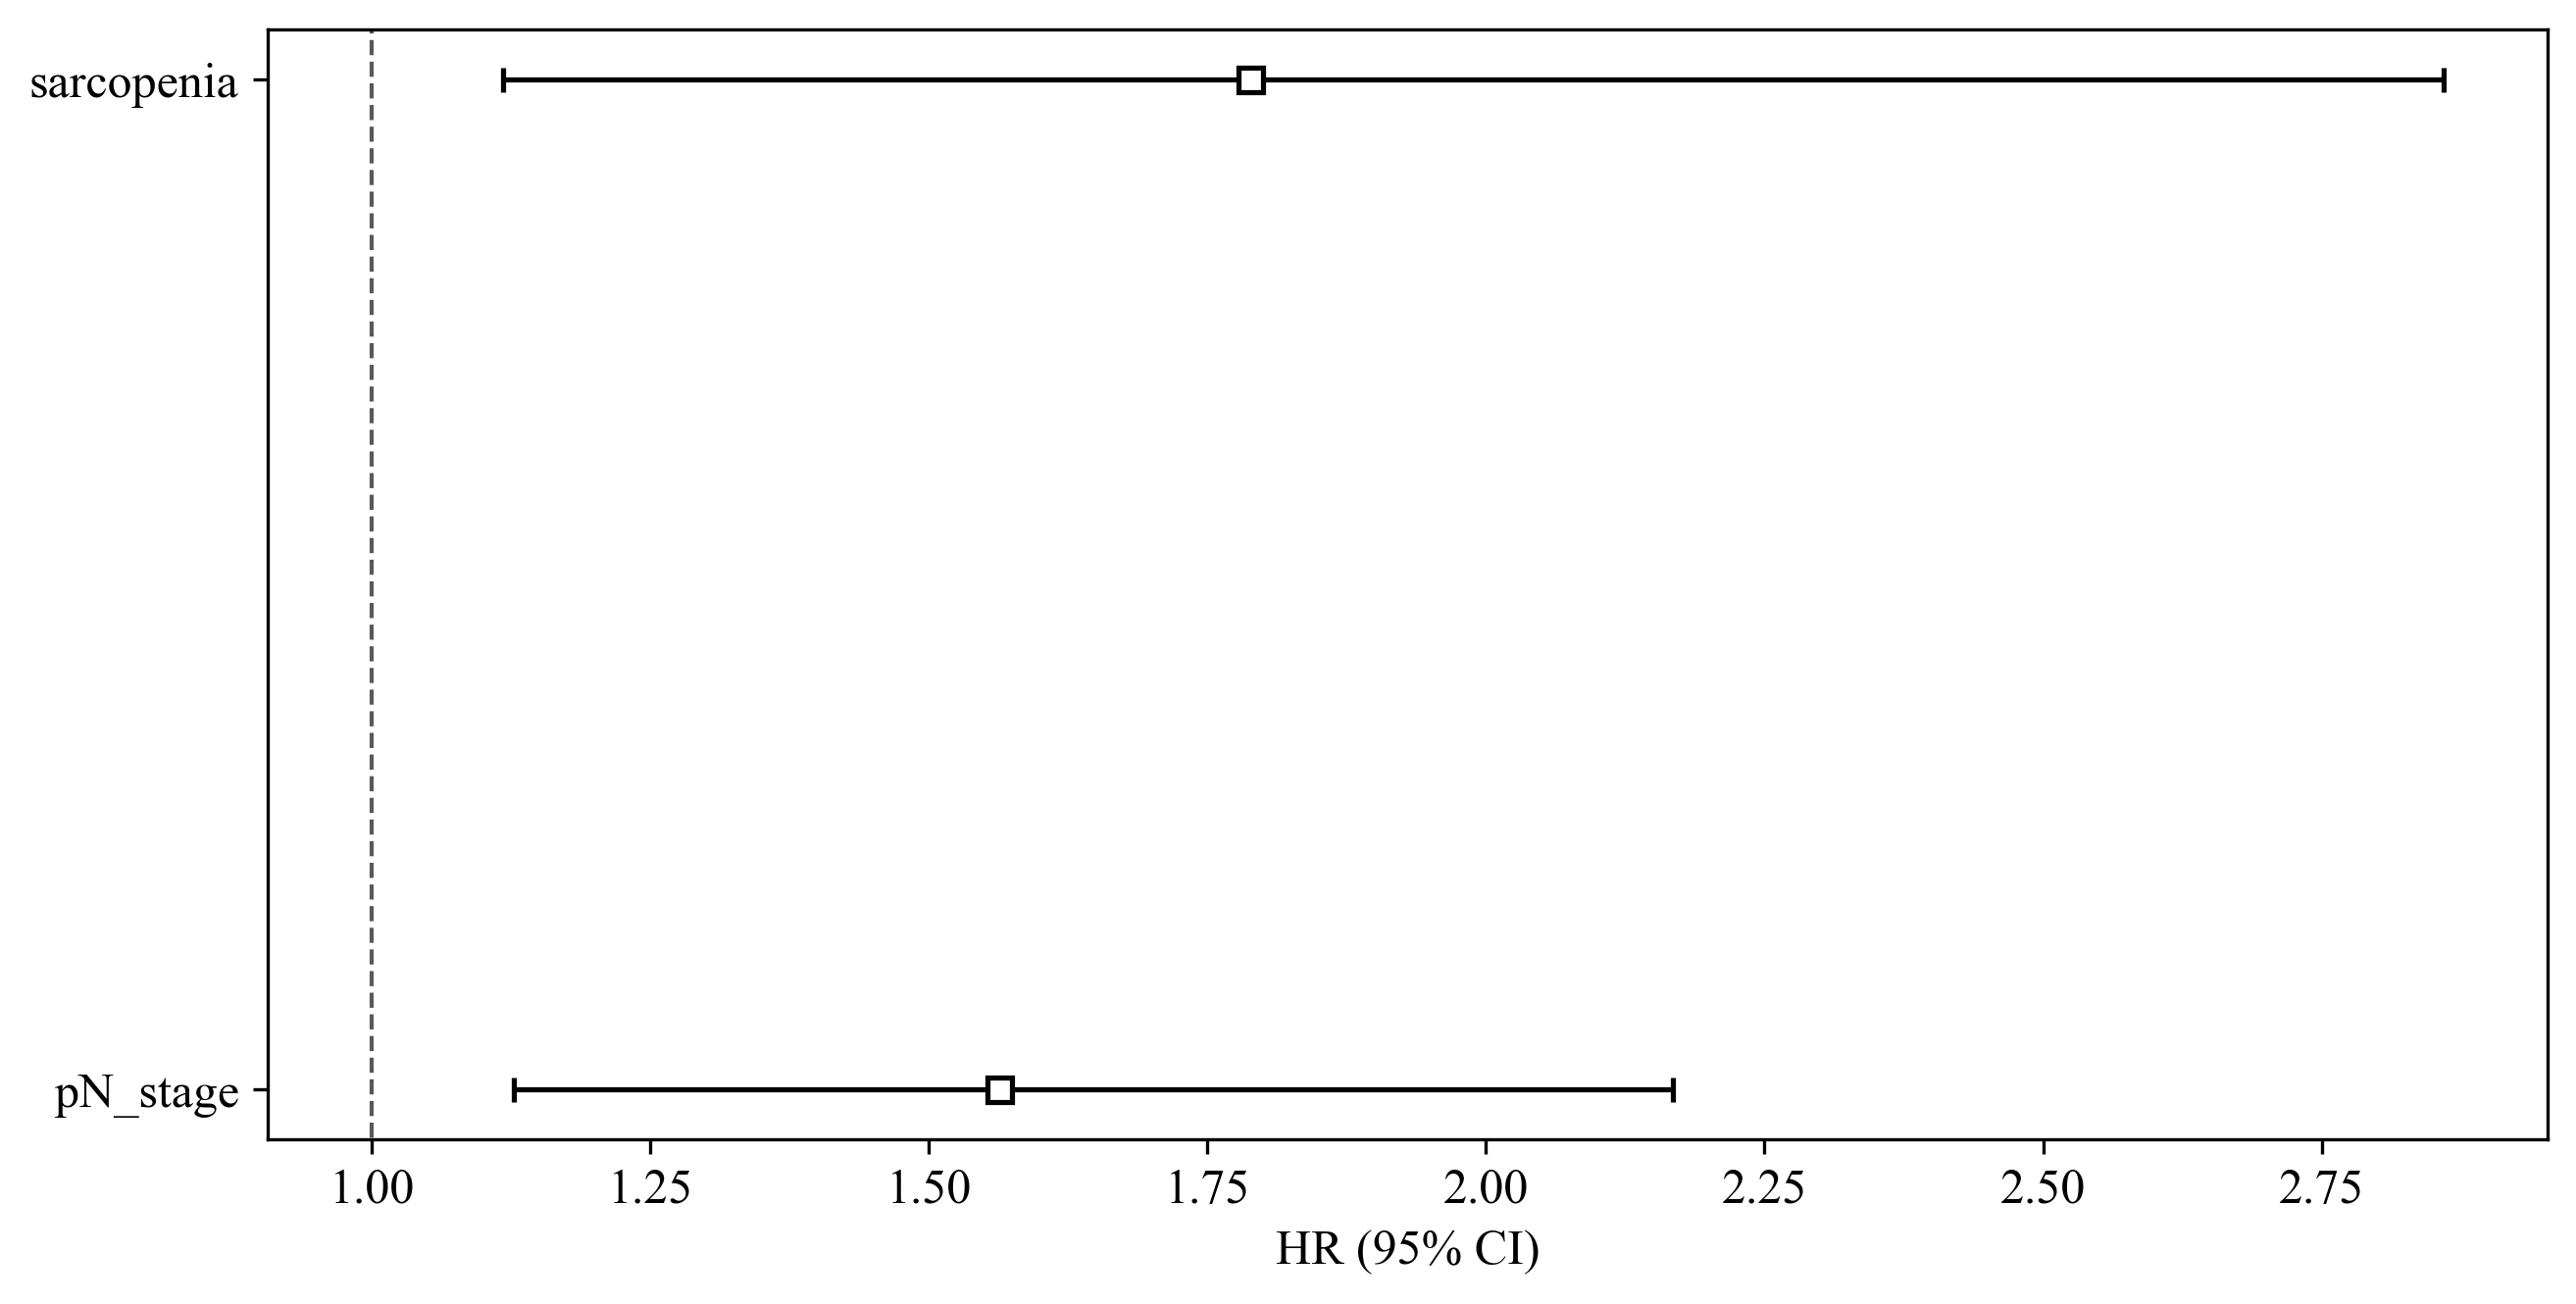

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
cph.plot(hazard_ratios=True)
plt.savefig('img/Clinic_feature_pvalue.svg')
plt.show()

# KM 曲线

根据HR进行分组，计算KM以及log ranktest

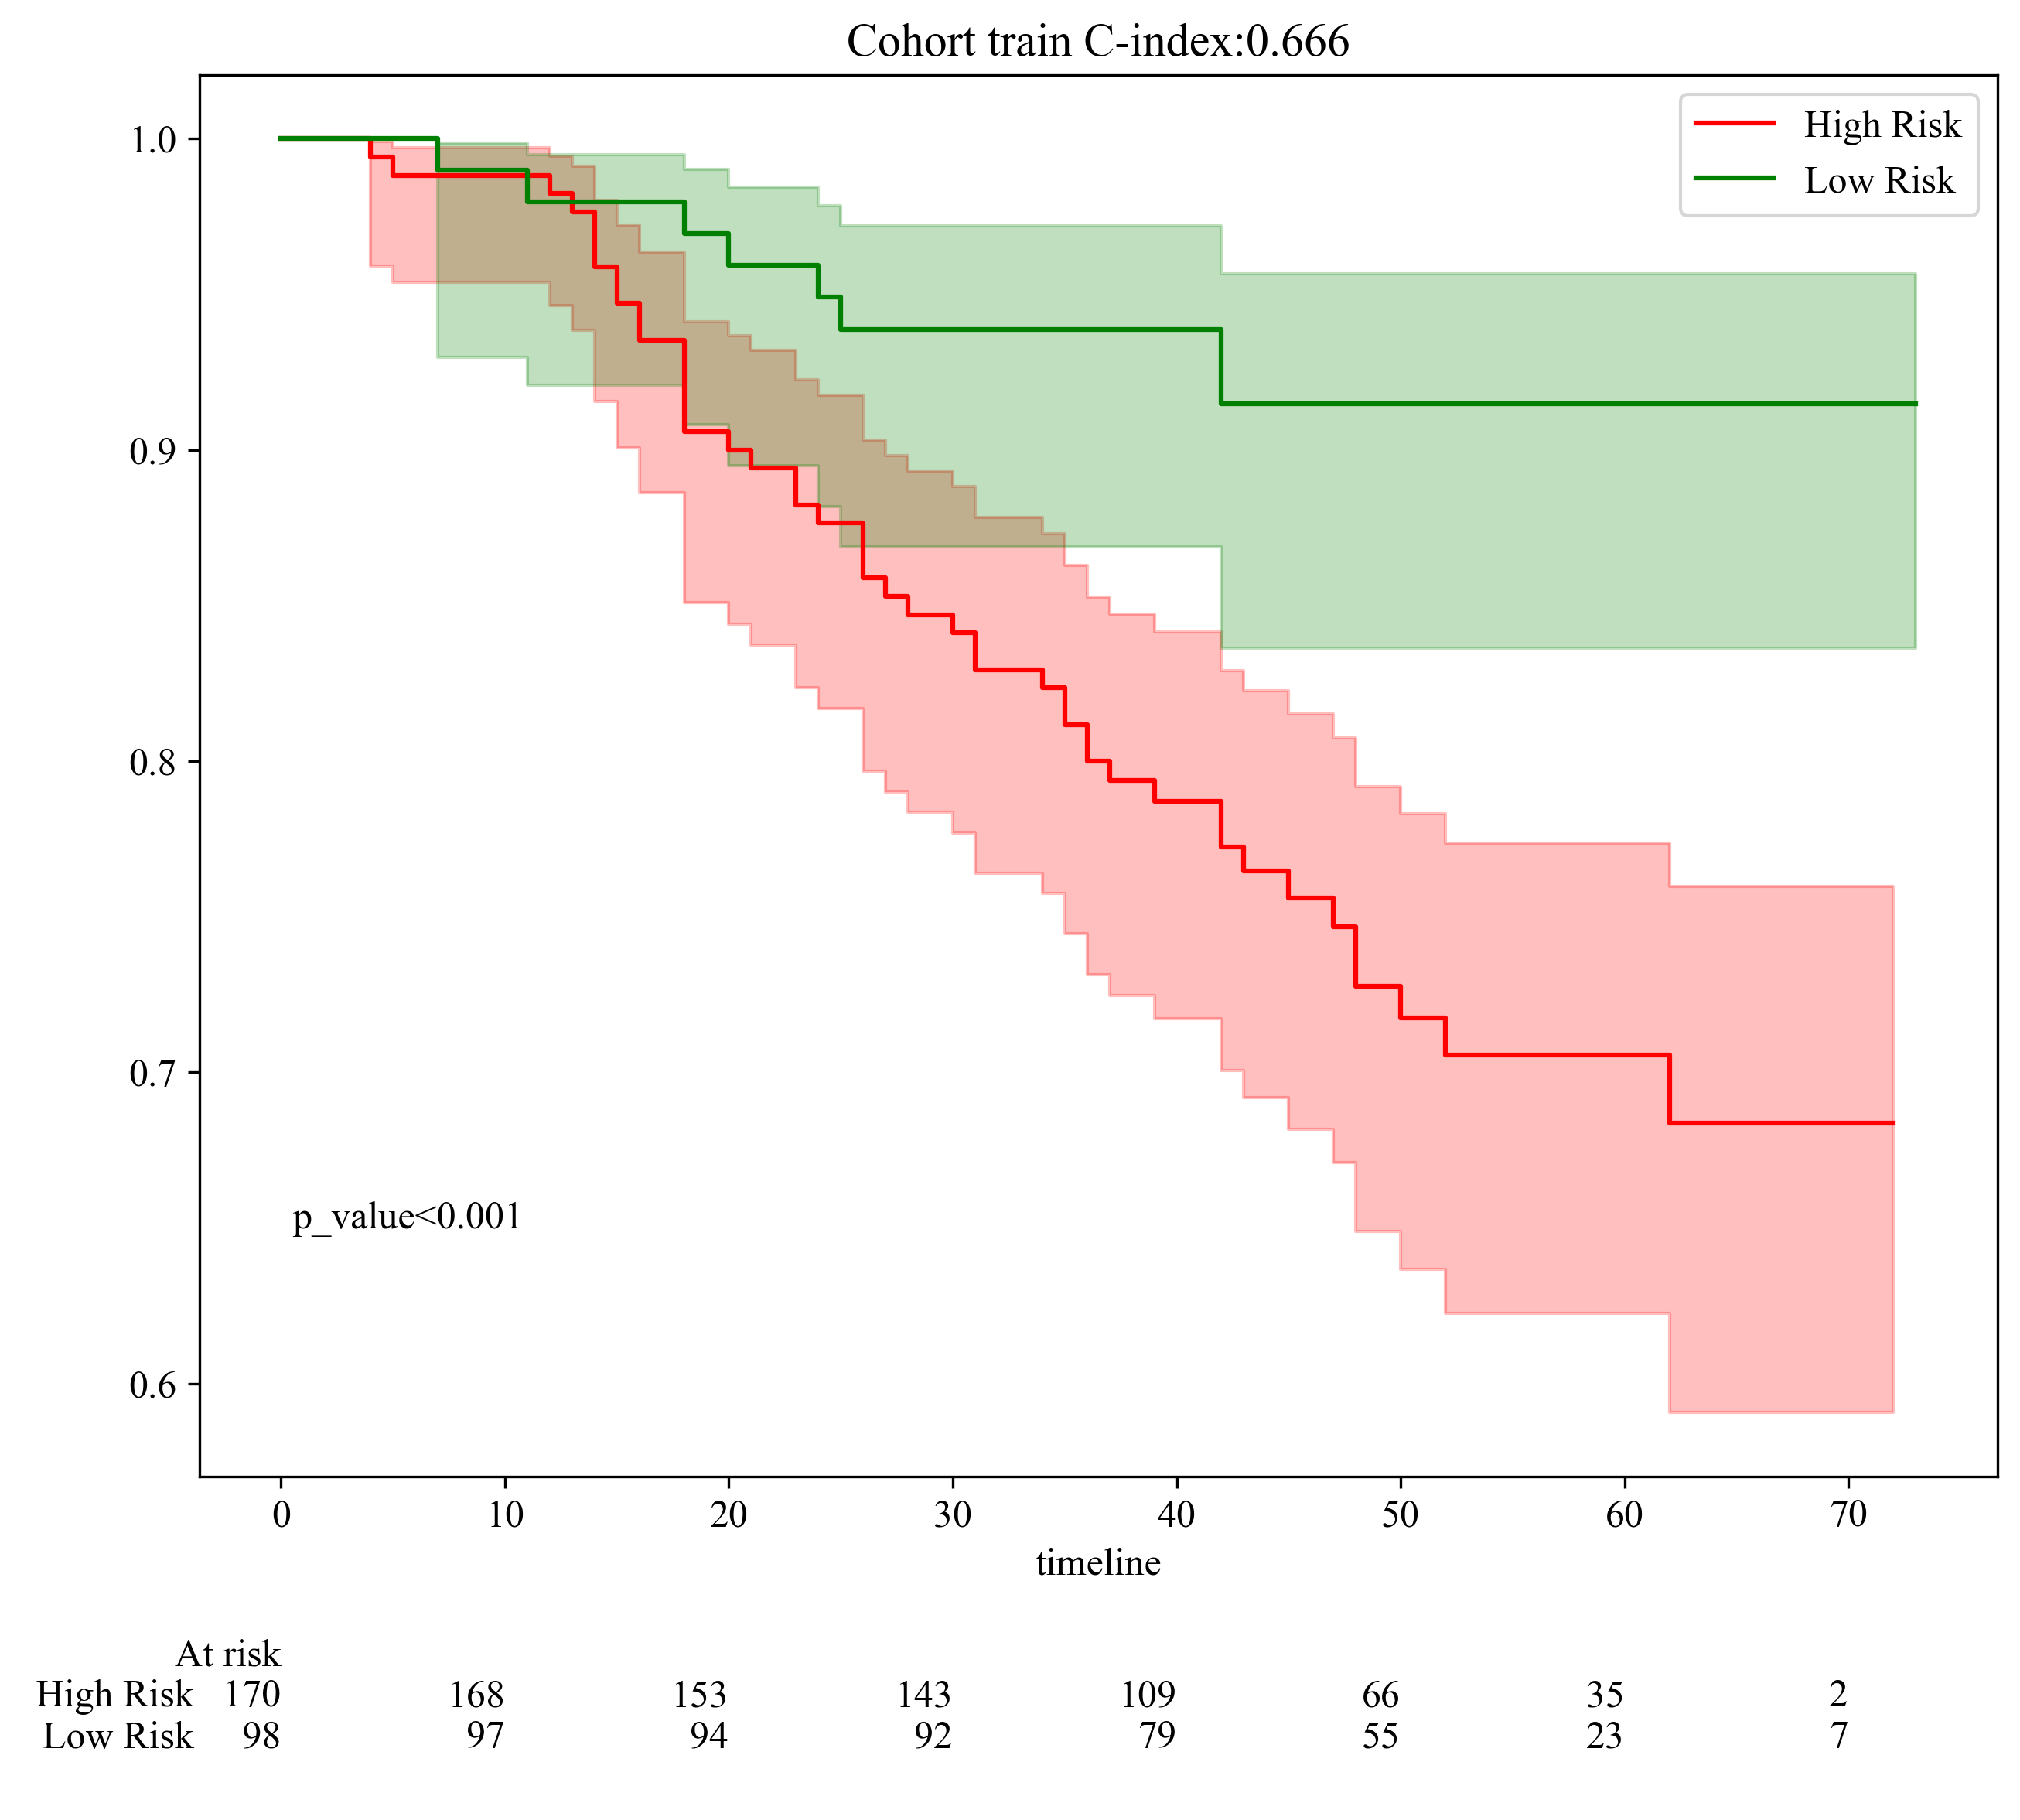

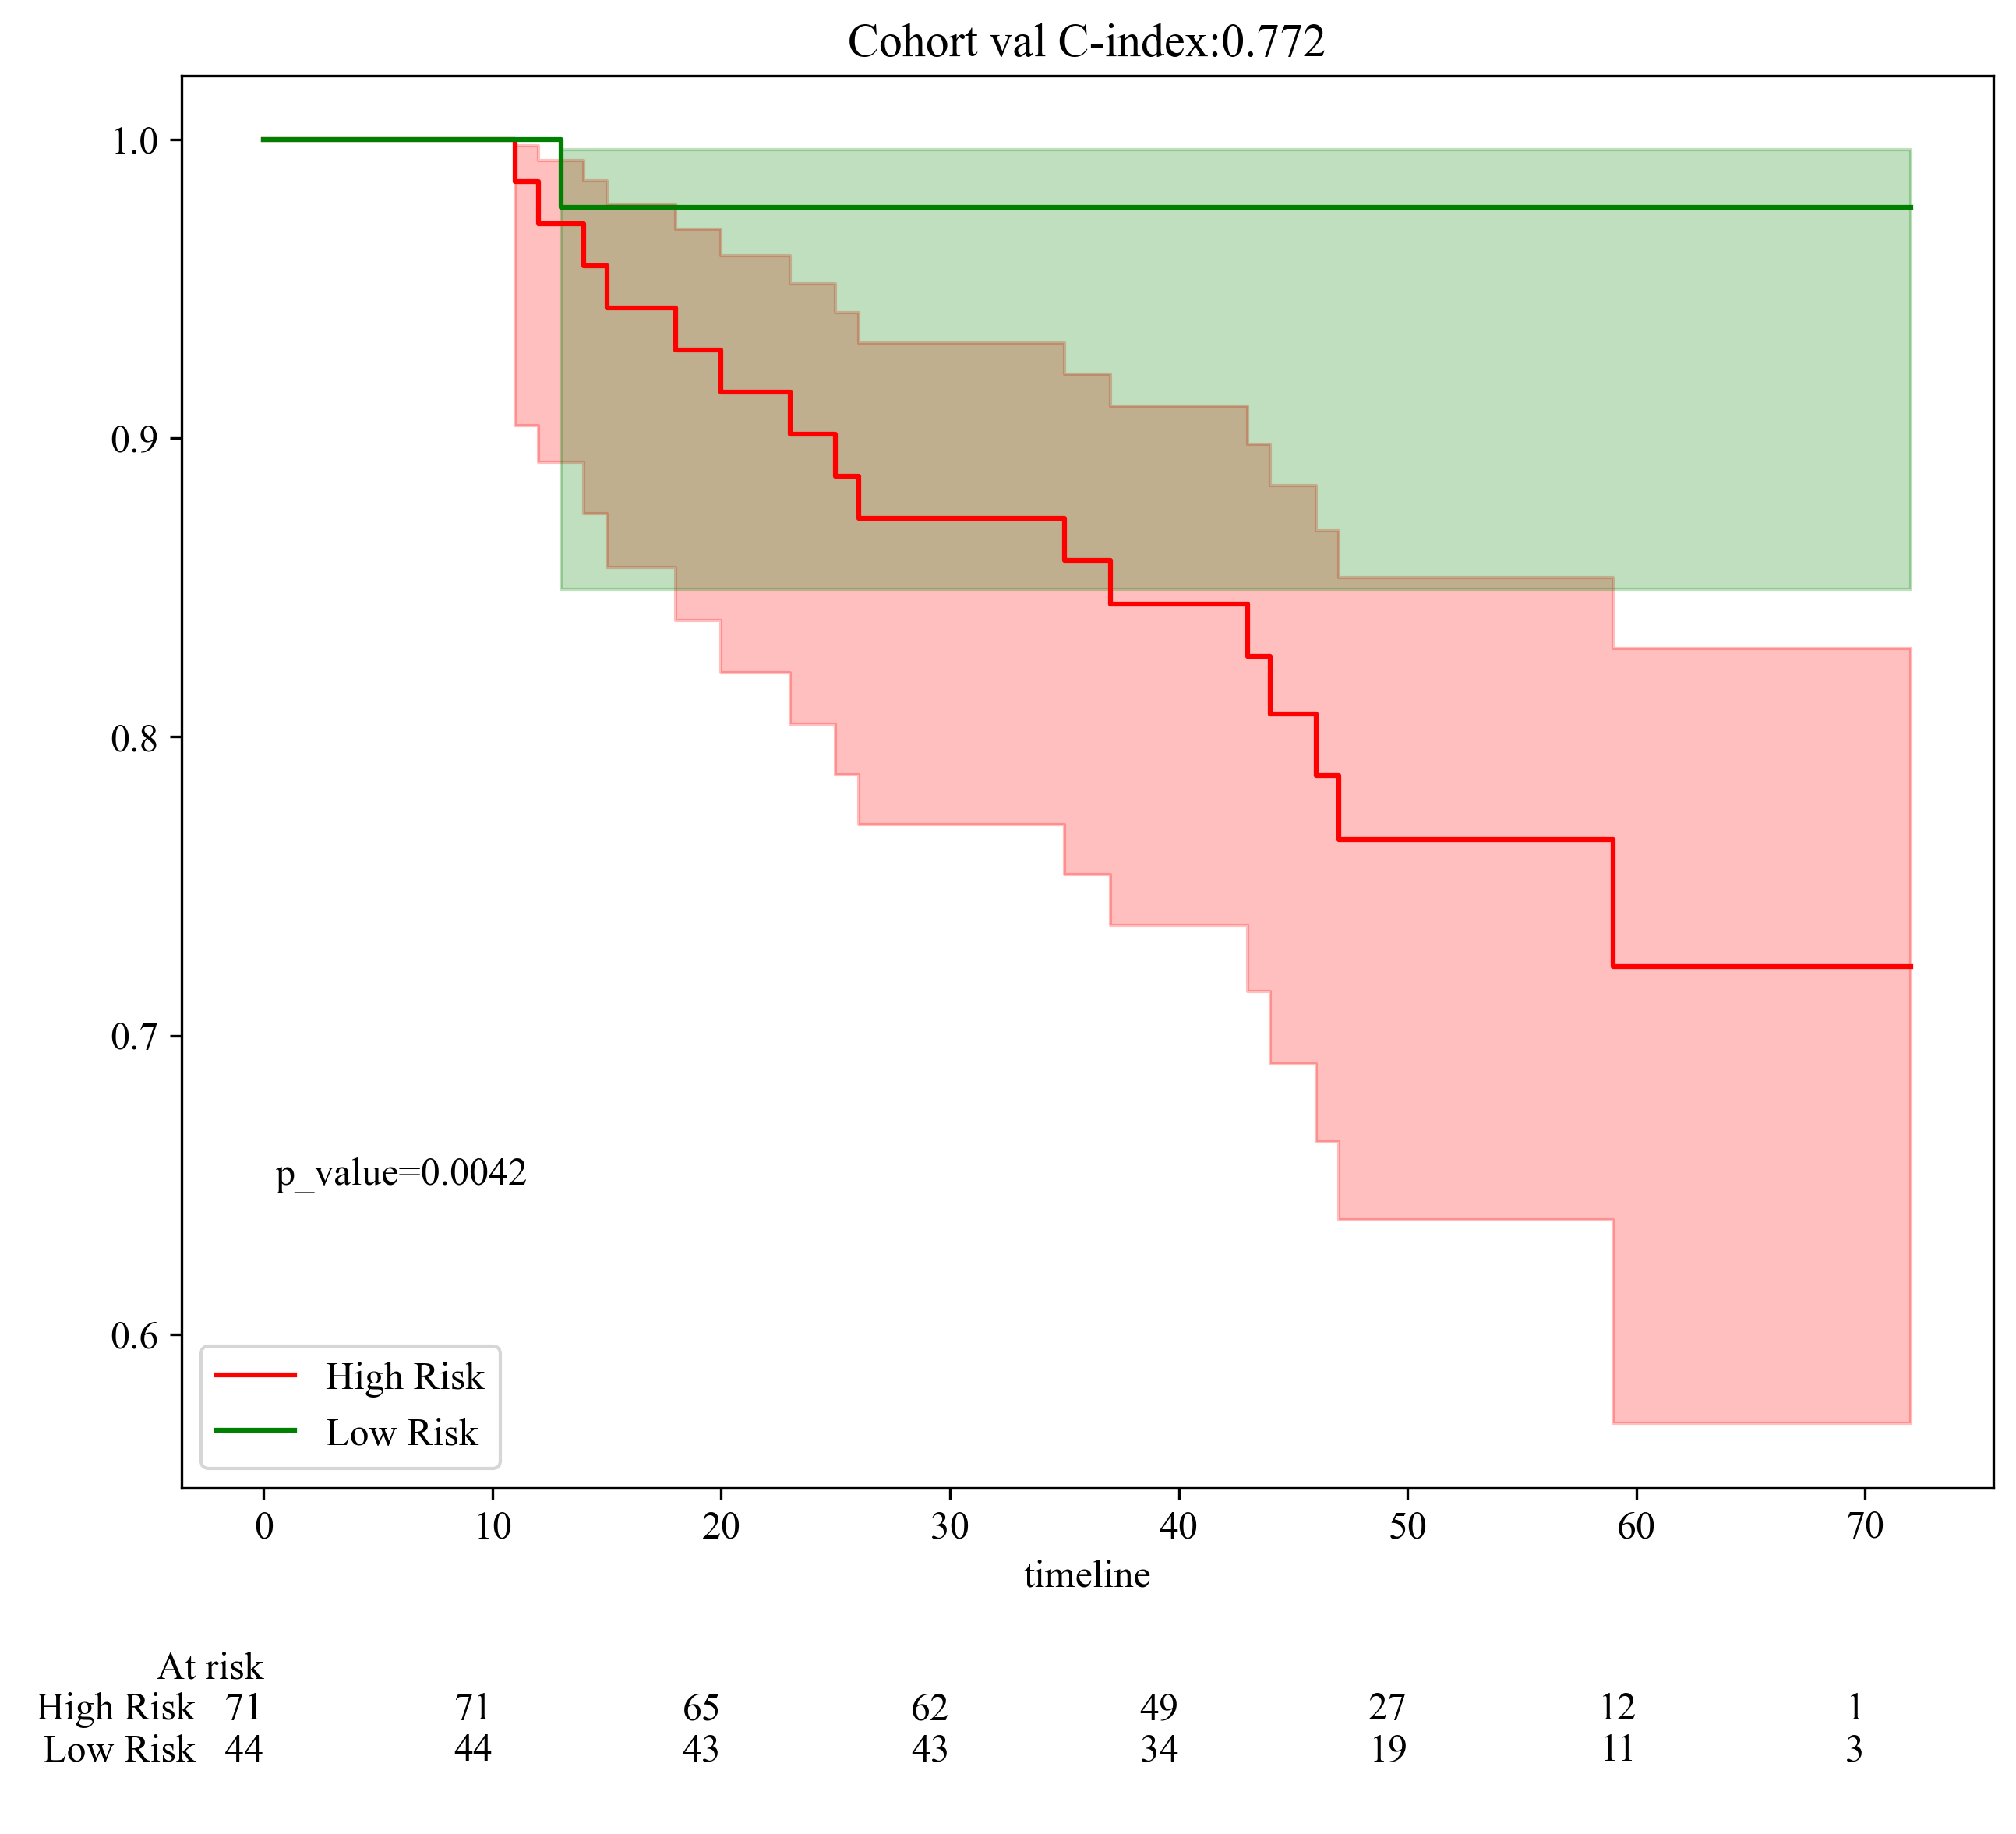

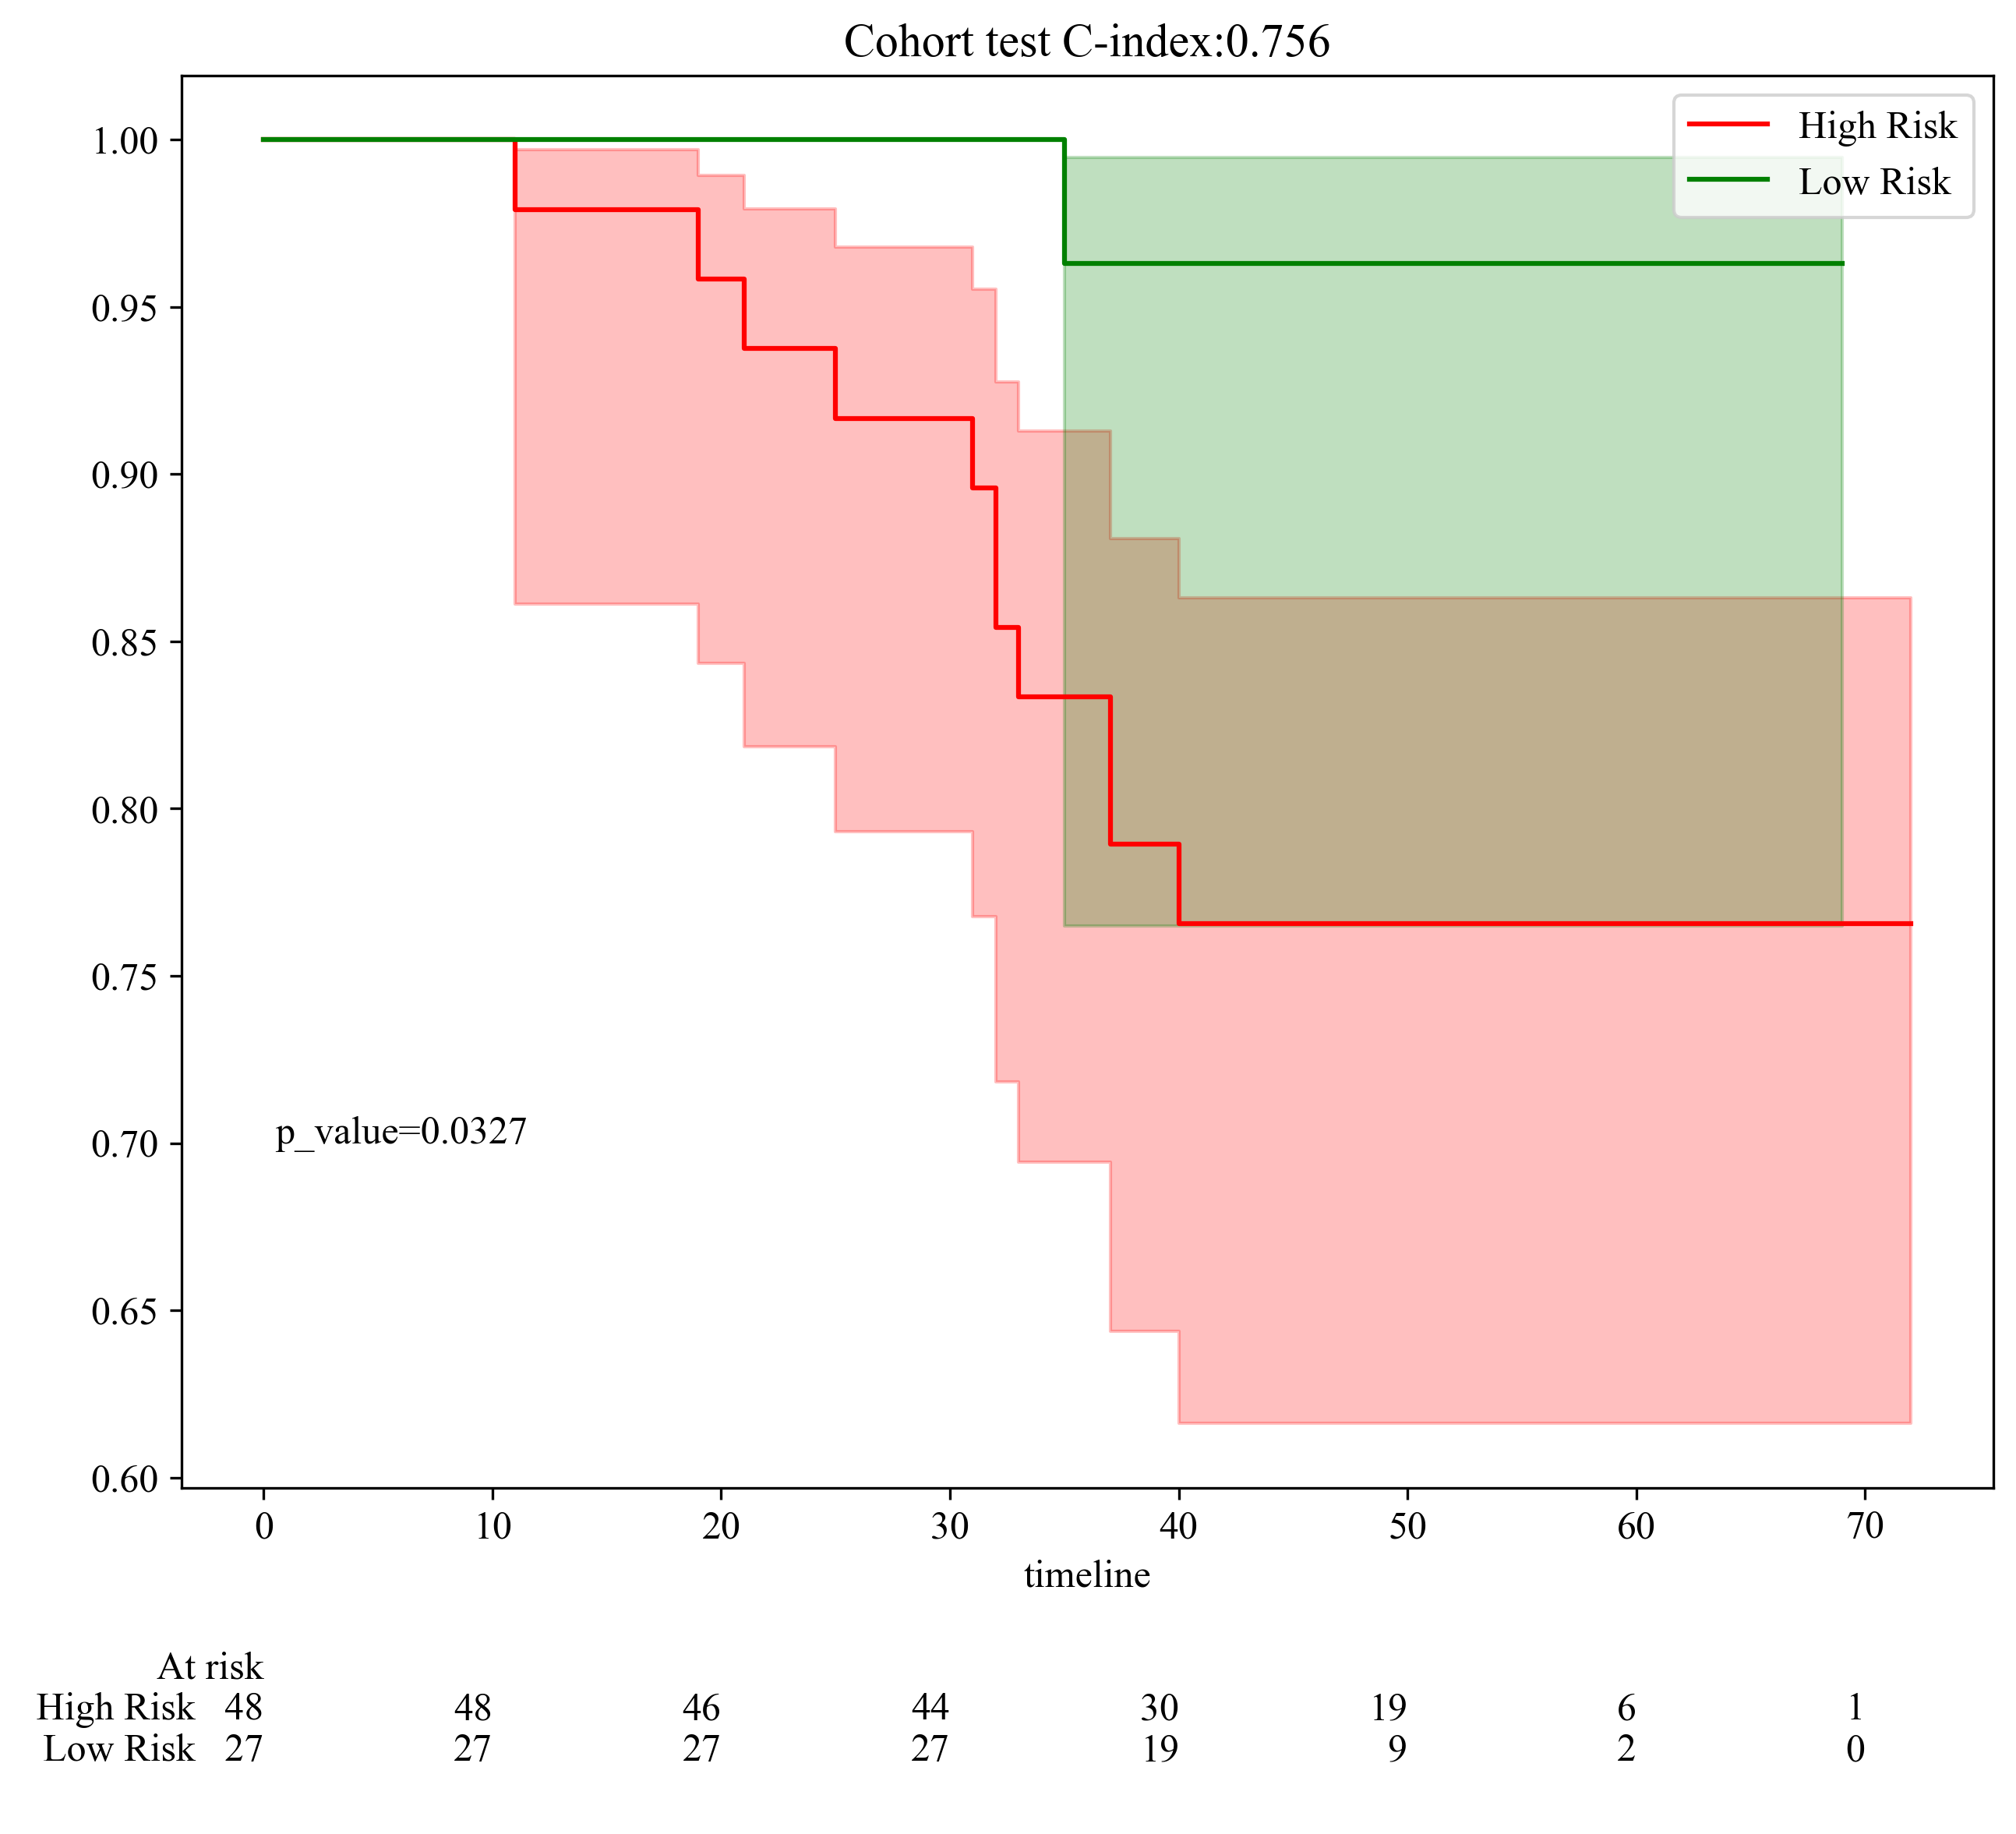

In [10]:
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts

thres = 0.001
bst_split = {'train': 1.03, 'val':1.03, 'test': 1.03}
loc = {'train': 0.65, 'val':0.65, 'test': 0.7}
for subset, test_data in val_datasets.items():
    c_index = cph.score(test_data[[c for c in test_data.columns if c != 'ID']], scoring_method="concordance_index")
#     y_pred = cph.predict_median(test_data[[c for c in test_data.columns if c != 'ID']])
#     cox_data = pd.concat([test_data, y_pred], axis=1)
#     mean = cox_data.describe()[0.5]['mean']
#     cox_data['HR'] = cox_data[0.5] < mean
    y_pred = cph.predict_partial_hazard(test_data[[c for c in test_data.columns if c != 'ID']])
    cox_data = pd.concat([test_data, y_pred], axis=1)
    mean = cox_data.describe()[0]['50%']
    cox_data['HR'] = cox_data[0] > bst_split[subset]
#     cox_data['HR'] = cox_data[0] > 1

    dem = (cox_data["HR"] == True)
    results = logrank_test(cox_data[duration_col][dem], cox_data[duration_col][~dem], 
                           event_observed_A=cox_data[event_col][dem], event_observed_B=cox_data[event_col][~dem])
    p_value = f"={results.p_value:.4f}" if results.p_value > thres else f'<{thres}'
    plt.title(f"Cohort {subset} C-index:{c_index:.3f}")
    if sum(dem):
        kmf_high = KaplanMeierFitter()
        kmf_high.fit(cox_data[duration_col][dem], event_observed=cox_data[event_col][dem], label="High Risk")
        kmf_high.plot_survival_function(color='r')
    if sum(~dem):
        kmf_low = KaplanMeierFitter()
        kmf_low.fit(cox_data[duration_col][~dem], event_observed=cox_data[event_col][~dem], label="Low Risk")
        kmf_low.plot_survival_function(color='g')
    plt.text(0.5, loc[subset], f"p_value{p_value}")
    add_at_risk_counts(kmf_high, kmf_low, rows_to_show=['At risk'])
    plt.savefig(f'img/{task_type}KM_{subset}.svg', bbox_inches='tight')
    plt.show()

In [11]:
import os
import numpy as np

def get_prediction(model: CoxPHFitter, data, ID=None, **kwargs):
    hr = model.predict_partial_hazard(data)
    expectation = model.predict_expectation(data)
    
    predictions = pd.concat([hr, expectation], axis=1)
    predictions.columns = ['HR', 'expectation']
    if ID is not None:
        predictions = pd.concat([ID, hr, expectation], axis=1)
        predictions.columns = ['ID', 'HR', 'expectation']
    else:
        predictions = pd.concat([hr, expectation], axis=1)
        predictions.columns = ['HR', 'expectation']
    return predictions

os.makedirs('results', exist_ok=True)
info = []
for subset, test_data in val_datasets.items():
    if subset in get_param_in_cwd('subsets'):
        results = get_prediction(cph, test_data, ID=test_data['ID'])
        results.to_csv(f'results/{task_type}cox_predictions_{subset}.csv', index=False)
        results['group'] = subset
        info.append(results)
        pd.merge(results, data[['ID', event_col, duration_col]], 
                 on='ID', how='inner').to_csv(f'features/{task_type}4xtile_{subset}.txt', index=False, sep='\t')
info = pd.concat(info, axis=0)
info

,ID,HR,expectation,group
0,primary-1.nii.gz,0.661,62.596,train
1,primary-3.nii.gz,1.617,54.674,train
2,primary-4.nii.gz,0.661,62.596,train
5,primary-10.nii.gz,0.661,62.596,train
7,primary-12.nii.gz,1.182,58.096,train
...,...,...,...,...
453,secondary2-66.nii.gz,0.661,62.596,test
454,secondary2-67.nii.gz,0.661,62.596,test
455,secondary2-69.nii.gz,1.034,59.332,test
456,secondary2-71.nii.gz,1.617,54.674,test
